<a href="https://colab.research.google.com/github/CarlosVargasF/Stage_Liris_Vargas/blob/master/Code/comparison_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install infomap
!pip install wurlitzer
!pip install leidenalg 
!pip install git+https://github.com/GiulioRossetti/cdlib.git > /dev/null
#!pip install cigram 

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for infomap: filename=infomap-1.1.3-cp36-cp36m-linux_x86_64.whl size=5683972 sha256=94ad11f0dc177d15949487eeb4e558ab513dc6550d01323ec2798f13ff60577e
  Stored in directory: /root/.cache/pip/wheels/63/31/ca/9ed0af4c2da472ea989c966c26a6ff448b76f39cb5db82960e
Successfully built infomap
     |████████████████████████████████| 2.4MB 2.8MB/s 
     |████████████████████████████████| 3.2MB 21.4MB/s 
  Running command git clone -q https://github.com/GiulioRossetti/cdlib.git /tmp/pip-req-build-77cjkvob


In [ ]:
from cdlib import algorithms
#from cdlib import viz
from cdlib import NodeClustering
from cdlib import evaluation
import networkx as nx
#from networkx.generators.community import LFR_benchmark_graph
import time
import pandas as pd
import numpy as np
#from cigram import lfr_benchmark_graph
import matplotlib.pyplot as plt
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

In [ ]:
def evaluate_and_compare(algos_list, case_list='all'):
  '''
  Possible values for <case_list>       [benchmark cases to evaluate] :
    - 'n1k_small'     [n=1000, minc=10, maxc=50]
    - 'n1k_big'       [n=1000, minc=10, maxc=50] 
    - 'n5k_small'     [n=5000, minc=20, maxc=100]
    - 'n5k_big'       [n=5000, minc=20, maxc=100]
    - 'all'           [perform evaluation over all 4 cases]

    * It is possible to select multiple cases passing them as a list.
  
  Possible values for <algos_list>       [algorithms to consider] :
    - 'gn'            [girvan_newman]
    - 'greedy'        [greedy_modularity (Clauset et al)]
    - 'louvain'       [louvain (Blondel et al)]
    - 'cfinder'       [kclique]
    - 'mcl'           [markov_clustering]
    - 'infomap'       [infomap]
    - 'em'            [expectation-maximization]
    - 'leiden'        [leiden]
  '''
  
  start_time = time.time()
  
  #Algorithms names list
  algos_names = {
    'gn'      : algorithms.girvan_newman,
    'greedy'  : algorithms.greedy_modularity,
    'louvain' : algorithms.louvain,
    'cfinder' : algorithms.kclique,
    'mcl'     : algorithms.markov_clustering,
    'infomap' : algorithms.infomap,
    'em'      : algorithms.em,
    'leiden'  : algorithms.leiden      
  }
  #Importing and reading benchmark files

  #Url base path
  url = 'https://github.com/CarlosVargasF/LFR_benchmarks_for_testing/raw/ae9c917c057cc8145da0103046ff0a690313fc57/'
  
  #Specific folders for undirected and unweighted benchmarks
  src_undir_unwei = {
    'n1k_small' : 'LFR_n1000_small/',
    'n1k_big'   : 'LFR_n1000_big/',
    'n5k_small' : 'LFR_n5000_small/',
    'n5k_big'   : 'LFR_n5000_big/'
  }

  #Graph type
  src = src_undir_unwei

  #Checking case parameter  
  if (case_list == 'all'):
    cases = [opt for opt in src]
  elif (isinstance(case_list, list)) and (len(case_list)): 
    for c in case_list:
      if not(c in src):
        raise ValueError('Invalid <case> option. Verify available cases.')
    cases = case_list    
  else:
    raise ValueError('Invalid <case> input format. Please insert a LIST of valide options or "all" for use all of them.')
  
  #Checking algo_name parameter
  if (isinstance(algos_list, list)) and (len(algos_list)): 
    for a in algos_list:
      if not(a in algos_names):
        raise ValueError('Invalid <algos_list> name. Verify available algorithm names.')
    algos = algos_list    
  else:
    raise ValueError('Invalid <algos_list> input format. Please insert a list of valide algorithm names.') 

  results = pd.DataFrame(columns=['Algorithm', 'Graph', 'Case', 'NMI', 'Exec_Time'])
  perfs = {}
  for case in cases:
    base_path = url + src[case]

    #Open zip files
    zip_comms = urlopen(base_path + 'cnl_files.zip')
    zip_edges = urlopen(base_path + 'nse_files.zip')
    zipfile_c = ZipFile(BytesIO(zip_comms.read()))
    zipfile_e = ZipFile(BytesIO(zip_edges.read()))

    #Read data files
    data_comms = [zipfile_c.open(line1).read().decode('utf-8').splitlines() for line1 in zipfile_c.namelist()]
    data_edges = [(zipfile_e.open(line2), line2) for line2 in zipfile_e.namelist()]
        
    #Construction of the lfr graphs
    lfr_graphs = [(nx.read_edgelist(edge_file[0], nodetype=int, data=False), edge_file[1]) for edge_file in data_edges]

    #Construction of the lfr communities
    lfr_comms = [[list(map(int, item.split())) for item in comm_file] for comm_file in data_comms]

    #Creation of NodeClustering objects     
    lfr_comms_nc = [NodeClustering(C, G[0], G[1]) for C, G in zip(lfr_comms, lfr_graphs)]

    #Application of algorithms over all the benchmarks
    perf_alg = {}
    calculated_comms = []    
    for alg in algos:
      algo_data = []
      for G in lfr_graphs:
        s_time = time.time()
        calculated_comms.append(algos_names[alg](G[0]))
        e_time = time.time() - s_time
        algo_data.append([alg, G[1], case, e_time])
      
      #Performance evaluation (NMI)
      perf = [evaluation.normalized_mutual_information(lfr, calculated) for lfr, calculated in zip(lfr_comms_nc, calculated_comms)]
      perf_df = pd.DataFrame(perf)
      init = 0
      avg_perf =[]
      for i in range(1,9):
        avg_perf.append(perf_df['score'].iloc[init:i*10].mean())
        init+=10    

      #Update of results
      algo_data_df = pd.DataFrame(algo_data, columns=['Algorithm', 'Graph', 'Case', 'Exec_Time'])
      algo_data_df['NMI'] = perf_df['score']
      results = pd.concat([results, algo_data_df], ignore_index=True)

      perf_alg[alg] = avg_perf
    perfs[case] = perf_alg    
  
  #Plotting NMI vs mixed parameter(mu)
  for alg in algos:
    fig = plt.figure()
    mu = np.linspace(0.1, 0.8, 8)
    for p in perfs:
      nmi = perfs[p][alg]
      nmi_mu_plt = plt.plot(mu, nmi, '-o', label=p) 
    plt.xlabel('Mixing parameter')
    plt.ylabel('Normalized Mutual Information')
    plt.title(alg)
    plt.legend(loc='lower left')      
  
  total_time = (time.time() - start_time)
  print("--- Total execution time: %d min %d sec ---" % (total_time//60, total_time%60))

  return results

--- Total execution time: 2 min 54 sec ---


,Algorithm,Graph,Case,NMI,Exec_Time
0,infomap,lfr_0.1_1.nse,n1k_small,1.000000e+00,0.073337
1,infomap,lfr_0.1_10.nse,n1k_small,1.000000e+00,0.074826
2,infomap,lfr_0.1_2.nse,n1k_small,1.000000e+00,0.071034
3,infomap,lfr_0.1_3.nse,n1k_small,1.000000e+00,0.070224
4,infomap,lfr_0.1_4.nse,n1k_small,1.000000e+00,0.071091
...,...,...,...,...,...
315,infomap,lfr_0.8_5.nse,n5k_big,3.177461e-16,0.918567
316,infomap,lfr_0.8_6.nse,n5k_big,3.253336e-16,0.958660
317,infomap,lfr_0.8_7.nse,n5k_big,3.565214e-16,0.926317
318,infomap,lfr_0.8_8.nse,n5k_big,3.396989e-16,0.935861


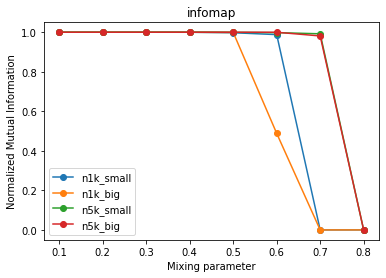

In [ ]:
p2 = evaluate_and_compare(['infomap'], 'all')
p2